In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import tensorkrowch as tk

In [2]:
torch.set_num_threads(1)
cwd = os.getcwd()
cwd = os.path.join(cwd, '..', '..')

## Random MPS and Slater

### TT-RSS

In [4]:
n_features_list = [100, 200, 500]
phys_dim = 2
bond_dim1 = 10
bond_dim2 = None
samples_size = 1000
# sketch_size_list = [10, 12, 14, 16, 18, 20]
sketch_size_list = [10, 15, 20, 25, 30, 35]

results_dir = os.path.join(cwd, 'results', '1_performance', 'random_mps')

errors_random_mps = {}
sketch_random_mps = {}
times_random_mps = {}

print('Medians:\n--------')
for n_features in n_features_list:
    print(f'N. Features: {n_features}')
    for sketch_size in sketch_size_list:
        bond_dim2 = sketch_size
        aux_dir = f'rss_{n_features}_{phys_dim}_{bond_dim1}_{bond_dim2}_{samples_size}_{sketch_size}'
        files = os.listdir(os.path.join(results_dir, aux_dir))
        
        aux_errors = torch.Tensor([float(f.split('_')[2]) for f in files])
        aux_sketch = torch.Tensor([float(f.split('_')[1]) for f in files])
        aux_times = torch.Tensor([float(f.split('_')[0]) for f in files])
        
        # Remove outliers
        # aux_errors, ids = aux_errors.sort()
        # aux_times = aux_times[ids]
        
        q = torch.Tensor([0.25, 0.75])
        quantiles = aux_errors.quantile(q=q)
        iqr = quantiles[1] - quantiles[0]
        cond = (aux_errors >= (quantiles[0] - 1.5 * iqr)) * (aux_errors <= (quantiles[1] + 1.5 * iqr))
        aux_errors = aux_errors[cond]
        
        quantiles = aux_sketch.quantile(q=q)
        iqr = quantiles[1] - quantiles[0]
        cond = (aux_sketch >= (quantiles[0] - 1.5 * iqr)) * (aux_sketch <= (quantiles[1] + 1.5 * iqr))
        aux_sketch = aux_sketch[cond]
        
        quantiles = aux_times.quantile(q=q)
        iqr = quantiles[1] - quantiles[0]
        cond = (aux_times >= (quantiles[0] - 1.5 * iqr)) * (aux_times <= (quantiles[1] + 1.5 * iqr))
        aux_times = aux_times[cond]
        
        print(f'\t{sketch_size} --> Sketch: {aux_sketch.median():.2e}, '
              f'Test: {aux_errors.median():.2e}, '
              f'Time: {aux_times.median():.2e}')
        
        if n_features not in errors_random_mps:
            errors_random_mps[n_features] = [(aux_errors.mean(), aux_errors.std())]
            sketch_random_mps[n_features] = [(aux_sketch.mean(), aux_sketch.std())]
            times_random_mps[n_features] = [(aux_times.mean(), aux_times.std())]
        else:
            errors_random_mps[n_features].append((aux_errors.mean(), aux_errors.std()))
            sketch_random_mps[n_features].append((aux_sketch.mean(), aux_sketch.std()))
            times_random_mps[n_features].append((aux_times.mean(), aux_times.std()))

print('\nMeans:\n------')
errors_random_mps

Medians:
--------
N. Features: 100
	10 --> Sketch: 2.85e-15, Test: 1.01e+00, Time: 1.07e+00
	15 --> Sketch: 3.72e-15, Test: 4.20e-01, Time: 1.19e+00
	20 --> Sketch: 3.36e-15, Test: 3.60e-01, Time: 1.97e+00
	25 --> Sketch: 3.64e-15, Test: 5.28e-15, Time: 4.25e+00
	30 --> Sketch: 3.21e-15, Test: 4.48e-15, Time: 5.39e+00
	35 --> Sketch: 3.65e-15, Test: 4.26e-15, Time: 4.25e+00
N. Features: 200
	10 --> Sketch: 5.00e-15, Test: 1.08e+00, Time: 2.40e+00
	15 --> Sketch: 5.50e-15, Test: 4.64e-01, Time: 4.96e+00
	20 --> Sketch: 5.38e-15, Test: 9.23e-15, Time: 7.08e+00
	25 --> Sketch: 4.86e-15, Test: 7.65e-15, Time: 9.50e+00
	30 --> Sketch: 5.20e-15, Test: 6.90e-15, Time: 1.16e+01
	35 --> Sketch: 4.78e-15, Test: 6.56e-15, Time: 1.89e+01
N. Features: 500
	10 --> Sketch: 8.97e-15, Test: 1.19e+00, Time: 8.58e+00
	15 --> Sketch: 7.07e-15, Test: 4.79e-01, Time: 1.39e+01
	20 --> Sketch: 8.95e-15, Test: 1.73e-01, Time: 2.45e+01
	25 --> Sketch: 8.57e-15, Test: 3.24e-01, Time: 5.06e+01
	30 --> Sketch: 7.1

{100: [(tensor(1.0630), tensor(0.1689)),
  (tensor(0.4514), tensor(0.1153)),
  (tensor(0.3588), tensor(0.1630)),
  (tensor(0.1367), tensor(0.1501)),
  (tensor(0.1397), tensor(0.1984)),
  (tensor(4.2475e-15), tensor(1.1829e-16))],
 200: [(tensor(1.3801), tensor(0.6583)),
  (tensor(0.5014), tensor(0.1836)),
  (tensor(0.1463), tensor(0.1685)),
  (tensor(0.1960), tensor(0.2263)),
  (tensor(0.0789), tensor(0.1322)),
  (tensor(0.1675), tensor(0.1803))],
 500: [(tensor(2.0384), tensor(1.7197)),
  (tensor(0.4848), tensor(0.1819)),
  (tensor(0.2366), tensor(0.2315)),
  (tensor(0.2233), tensor(0.1809)),
  (tensor(1.0399e-14), tensor(3.2173e-16)),
  (tensor(9.8700e-15), tensor(3.4180e-16))]}

In [5]:
L = 10.
m = 5
d_list = [20, 40, 100]
phys_dim = 2
bond_dim = 10
samples_size = 1000
sketch_size_list = [30, 40, 50, 60, 70, 80, 90, 100]

results_dir = os.path.join(cwd, 'results', '1_performance', 'slater_functions')

errors_slater = {}
sketch_slater = {}
times_slater = {}

print('Medians:\n--------')
for d in d_list:
    n_features = m*d
    print(f'N. Features: {n_features}')
    for sketch_size in sketch_size_list:
        aux_dir = f'rss_{L}_{m}_{d}_{bond_dim}_{samples_size}_{sketch_size}'
        files = os.listdir(os.path.join(results_dir, aux_dir))
        
        aux_errors = torch.Tensor([float(f.split('_')[-1][:-3]) for f in files])
        aux_sketch = torch.Tensor([float(f.split('_')[1]) for f in files])
        aux_times = torch.Tensor([float(f.split('_')[0]) for f in files])
        
        # Remove outliers
        # aux_errors, ids = aux_errors.sort()
        # aux_times = aux_times[ids]
        
        q = torch.Tensor([0.25, 0.75])
        quantiles = aux_errors.quantile(q=q)
        iqr = quantiles[1] - quantiles[0]
        cond = (aux_errors >= (quantiles[0] - 1.5 * iqr)) * (aux_errors <= (quantiles[1] + 1.5 * iqr))
        aux_errors = aux_errors[cond]
        
        quantiles = aux_sketch.quantile(q=q)
        iqr = quantiles[1] - quantiles[0]
        cond = (aux_sketch >= (quantiles[0] - 1.5 * iqr)) * (aux_sketch <= (quantiles[1] + 1.5 * iqr))
        aux_sketch = aux_sketch[cond]
        
        quantiles = aux_times.quantile(q=q)
        iqr = quantiles[1] - quantiles[0]
        cond = (aux_times >= (quantiles[0] - 1.5 * iqr)) * (aux_times <= (quantiles[1] + 1.5 * iqr))
        aux_times = aux_times[cond]
        
        print(f'\t{sketch_size} --> Sketch: {aux_sketch.median():.2e}, '
              f'Test: {aux_errors.median():.2e}, '
              f'Time: {aux_times.median():.2e}')
        
        if n_features not in errors_slater:
            errors_slater[n_features] = [(aux_errors.mean(), aux_errors.std())]
            sketch_slater[n_features] = [(aux_sketch.mean(), aux_sketch.std())]
            times_slater[n_features] = [(aux_times.mean(), aux_times.std())]
        else:
            errors_slater[n_features].append((aux_errors.mean(), aux_errors.std()))
            sketch_slater[n_features].append((aux_sketch.mean(), aux_sketch.std()))
            times_slater[n_features].append((aux_times.mean(), aux_times.std()))

print('\nMeans:\n------')
errors_slater

Medians:
--------
N. Features: 100
	30 --> Sketch: 6.51e-03, Test: 2.23e+00, Time: 4.85e+00
	40 --> Sketch: 6.58e-03, Test: 6.04e-01, Time: 7.22e+00
	50 --> Sketch: 2.81e-02, Test: 8.06e-01, Time: 7.70e+00
	60 --> Sketch: 9.87e-03, Test: 3.95e-01, Time: 1.16e+01
	70 --> Sketch: 1.02e-02, Test: 3.57e-01, Time: 1.66e+01
	80 --> Sketch: 8.89e-03, Test: 3.00e-01, Time: 1.82e+01
	90 --> Sketch: 1.29e-02, Test: 3.74e-01, Time: 2.33e+01
	100 --> Sketch: 9.76e-03, Test: 1.58e-01, Time: 2.76e+01
N. Features: 200
	30 --> Sketch: 3.65e-03, Test: 8.21e-01, Time: 9.03e+00
	40 --> Sketch: 1.24e-02, Test: 4.79e-01, Time: 1.41e+01
	50 --> Sketch: 2.24e-02, Test: 3.69e-01, Time: 1.76e+01
	60 --> Sketch: 1.75e-02, Test: 4.42e-01, Time: 2.26e+01
	70 --> Sketch: 1.62e-02, Test: 3.18e-01, Time: 2.83e+01
	80 --> Sketch: 1.15e-02, Test: 3.21e-01, Time: 3.71e+01
	90 --> Sketch: 2.33e-02, Test: 3.90e-01, Time: 4.50e+01
	100 --> Sketch: 2.45e-02, Test: 2.12e-01, Time: 5.57e+01
N. Features: 500
	30 --> Sketch: 3

{100: [(tensor(2.3277), tensor(1.6535)),
  (tensor(0.6600), tensor(0.4381)),
  (tensor(0.9557), tensor(0.4334)),
  (tensor(0.3410), tensor(0.2238)),
  (tensor(0.9742), tensor(1.1816)),
  (tensor(0.4960), tensor(0.5607)),
  (tensor(0.6084), tensor(0.6135)),
  (tensor(0.1653), tensor(0.0762))],
 200: [(tensor(1.4391), tensor(1.1412)),
  (tensor(0.5898), tensor(0.2370)),
  (tensor(0.6900), tensor(0.5679)),
  (tensor(0.4170), tensor(0.1621)),
  (tensor(0.5406), tensor(0.4827)),
  (tensor(0.2862), tensor(0.1379)),
  (tensor(0.4401), tensor(0.1715)),
  (tensor(0.6320), tensor(0.9692))],
 500: [(tensor(0.9962), tensor(0.9200)),
  (tensor(0.4864), tensor(0.2528)),
  (tensor(0.4768), tensor(0.3186)),
  (tensor(0.4789), tensor(0.2973)),
  (tensor(0.2940), tensor(0.1796)),
  (tensor(0.4709), tensor(0.4828)),
  (tensor(0.4746), tensor(0.2667)),
  (tensor(0.2942), tensor(0.2847))]}

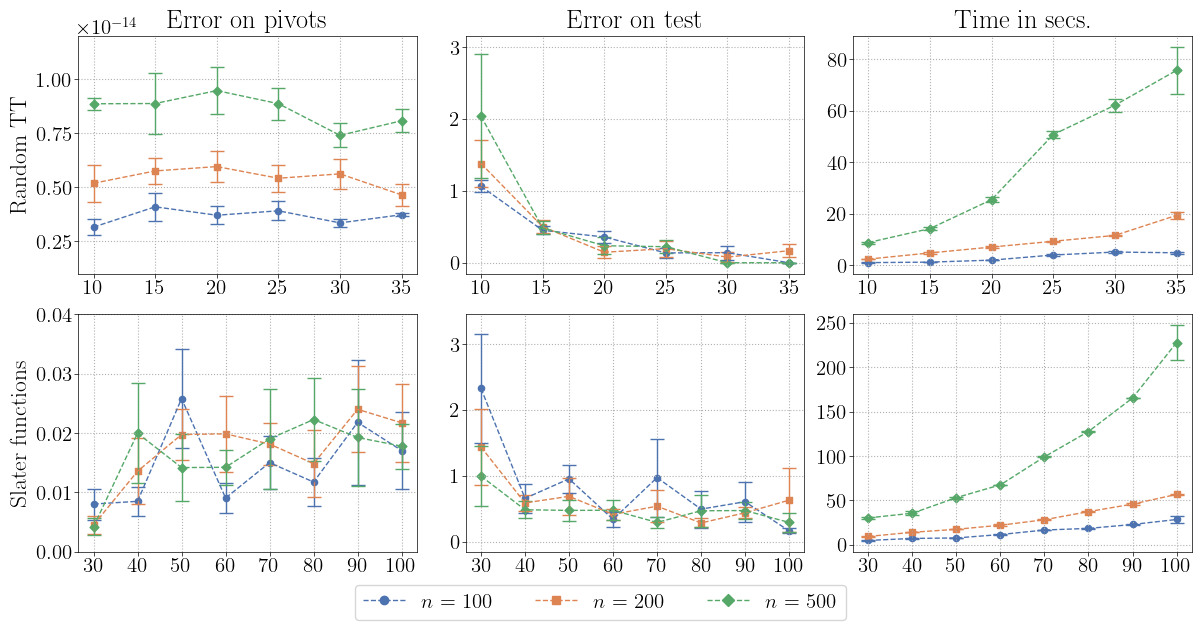

In [13]:
palette = sns.color_palette("deep")
colors = palette[0], palette[1], palette[2]

plt.rc('font', family='serif', serif='Computer Modern', size=16)
plt.rc('text', usetex=True)


# Set global font sizes
plt.rcParams['axes.linewidth'] = 0.5  # Default is usually 1.0
plt.rcParams['axes.titlesize'] = 19  # Title font size
plt.rcParams['axes.labelsize'] = 17  # Axis label font size
plt.rcParams['xtick.labelsize'] = 15  # X-axis tick label font size
plt.rcParams['ytick.labelsize'] = 15  # Y-axis tick label font size
plt.rcParams['legend.fontsize'] = 15


markers = ['o', 's', 'D']
labels = [r'$n$ = 100', r'$n$ = 200', r'$n$ = 500']

fig, axs = plt.subplots(2, 3, figsize=(12, 6))


# Random MPS
# ----------
# sketch_size_list = [10, 12, 14, 16, 18, 20]
sketch_size_list = [10, 15, 20, 25, 30, 35]

# Sketch
for i, n_features in enumerate([100, 200, 500]):
    means = torch.stack(list(map(lambda t: t[0],
                                 sketch_random_mps[n_features]))).tolist()
    stds = torch.stack(list(map(lambda t: t[1] * 0.5,
                                sketch_random_mps[n_features]))).tolist()

    axs[0, 0].errorbar(x=sketch_size_list, y=means, yerr=stds, capsize=5.,
                       linestyle='--', linewidth=1., color=colors[i])
    axs[0, 0].scatter(x=sketch_size_list, y=means, s=20.,
                      color=colors[i], marker=markers[i], label=labels[i])

# Set axes
axs[0, 0].set_ylabel('Random TT')
axs[0, 0].set_title('Error on pivots')

# axs[0, 0].set_ylim(0, 0.75 * 1e-5)
axs[0, 0].set_ylim(0.1 * 1e-14, 1.2 * 1e-14)
axs[0, 0].yaxis.grid(linestyle=':')
axs[0, 0].xaxis.grid(linestyle=':')

# axs[0, 0].set_xticks(torch.arange(10, 22, 2))
axs[0, 0].set_xticks(torch.arange(10, 40, 5))


# Errors
for i, n_features in enumerate([100, 200, 500]):
    means = torch.stack(list(map(lambda t: t[0],
                                 errors_random_mps[n_features]))).tolist()
    stds = torch.stack(list(map(lambda t: t[1] * 0.5,
                                errors_random_mps[n_features]))).tolist()

    axs[0, 1].errorbar(x=sketch_size_list, y=means, yerr=stds, capsize=5.,
                       linestyle='--', linewidth=1., color=colors[i])
    axs[0, 1].scatter(x=sketch_size_list, y=means, s=20.,
                      color=colors[i], marker=markers[i], label=labels[i])

# Set axes
axs[0, 1].set_title('Error on test')

# axs[0, 1].set_ylim(0, 1.95)
axs[0, 1].set_ylim(-0.15, 3.15)
axs[0, 1].yaxis.grid(linestyle=':')
axs[0, 1].xaxis.grid(linestyle=':')

# axs[0, 1].set_xticks(torch.arange(10, 22, 2))
axs[0, 1].set_xticks(torch.arange(10, 40, 5))


# Times
for i, n_features in enumerate([100, 200, 500]):
    means = torch.stack(list(map(lambda t: t[0],
                                 times_random_mps[n_features]))).tolist()
    stds = torch.stack(list(map(lambda t: t[1] * 0.5,
                                times_random_mps[n_features]))).tolist()

    axs[0, 2].errorbar(x=sketch_size_list, y=means, yerr=stds, capsize=5.,
                       linestyle='--', linewidth=1., color=colors[i])
    axs[0, 2].scatter(x=sketch_size_list, y=means, s=20.,
                      color=colors[i], marker=markers[i], label=labels[i])

# Set axes
axs[0, 2].set_title('Time in secs.')

axs[0, 2].yaxis.grid(linestyle=':')
axs[0, 2].xaxis.grid(linestyle=':')

# axs[0, 2].set_xticks(torch.arange(10, 22, 2))
axs[0, 2].set_xticks(torch.arange(10, 40, 5))
# axs[0, 2].set_yticks(torch.arange(0, 32, 4))


# Slater
# ------
sketch_size_list = [30, 40, 50, 60, 70, 80, 90, 100]

# Sketch
for i, n_features in enumerate([100, 200, 500]):
    means = torch.stack(list(map(lambda t: t[0],
                                 sketch_slater[n_features]))).tolist()
    stds = torch.stack(list(map(lambda t: t[1] * 0.5,
                                sketch_slater[n_features]))).tolist()

    axs[1, 0].errorbar(x=sketch_size_list, y=means, yerr=stds, capsize=5.,
                       linestyle='--', linewidth=1., color=colors[i])
    axs[1, 0].scatter(x=sketch_size_list, y=means, s=20.,
                      color=colors[i], marker=markers[i], label=labels[i])

# Set axes
axs[1, 0].set_ylabel('Slater functions')

# axs[1, 0].set_ylim(0, 0.045)
axs[1, 0].set_ylim(0, 0.04)
axs[1, 0].yaxis.grid(linestyle=':')
axs[1, 0].xaxis.grid(linestyle=':')

axs[1, 0].set_xticks(torch.arange(30, 110, 10))

# Errors
for i, n_features in enumerate([100, 200, 500]):
    means = torch.stack(list(map(lambda t: t[0],
                                 errors_slater[n_features]))).tolist()
    stds = torch.stack(list(map(lambda t: t[1] * 0.5,
                                errors_slater[n_features]))).tolist()

    axs[1, 1].errorbar(x=sketch_size_list, y=means, yerr=stds, capsize=5.,
                       linestyle='--', linewidth=1., color=colors[i])
    axs[1, 1].scatter(x=sketch_size_list, y=means, s=20.,
                      color=colors[i], marker=markers[i], label=labels[i])

# Set axes
# axs[1, 1].set_ylim(0, 5.2)
axs[1, 1].set_ylim(-0.15, 3.45)
axs[1, 1].yaxis.grid(linestyle=':')
axs[1, 1].xaxis.grid(linestyle=':')

axs[1, 1].set_xticks(torch.arange(30, 110, 10))
# axs[1, 1].set_yticks(torch.arange(0, 6, 1))


# Times
for i, n_features in enumerate([100, 200, 500]):
    means = torch.stack(list(map(lambda t: t[0],
                                 times_slater[n_features]))).tolist()
    stds = torch.stack(list(map(lambda t: t[1] * 0.5,
                                times_slater[n_features]))).tolist()

    axs[1, 2].errorbar(x=sketch_size_list, y=means, yerr=stds, capsize=5.,
                       linestyle='--', linewidth=1., color=colors[i])
    axs[1, 2].scatter(x=sketch_size_list, y=means, s=20.,
                      color=colors[i], marker=markers[i], label=labels[i])

# Set axes
axs[1, 2].yaxis.grid(linestyle=':')
axs[1, 2].xaxis.grid(linestyle=':')

axs[1, 2].set_xticks(torch.arange(30, 110, 10))
# axs[1, 2].set_yticks(torch.arange(0, 140, 25))
axs[1, 2].set_yticks(torch.arange(0, 300, 50))


# Create custom legend handles
from matplotlib.lines import Line2D

custom_handles = [
    Line2D([0], [0], color=color, linestyle='--', marker=marker, markersize=6, linewidth=1., label=label)
    for color, marker, label in zip(colors, markers, labels)
]

# Add a single legend to the figure
fig.legend(
    handles=custom_handles,
    loc='lower center',
    ncol=3,
    bbox_to_anchor=(0.5, -0.075),  # Centered below the plots
    # frameon=False
)


plt.tight_layout(pad=0.25)


for i in range(2):
    for j in range(3):
        axs[i, j].tick_params(axis='both', which='major', pad=1,
                              direction='out', length=3, width=0.5)  # Default is usually around 6-10
        axs[i, j].tick_params(axis='both', which='minor', pad=1,
                              direction='out', length=3, width=0.5)

results_dir = os.path.join(cwd, 'results', '1_performance')
plt.savefig(os.path.join(results_dir, 'performance_slater_random.pdf'),
            bbox_inches='tight')

plt.show()

### TT-CI

In [ ]:
n_features_list = [100, 200] #, 500]
phys_dim = 2
bond_dim1 = 10
bond_dim2 = bond_dim1
samples_size = 1000

results_dir = os.path.join(cwd, 'results', '1_performance', 'random_mps')

errors_random_mps = {}
tot_times_random_mps = {}
times_random_mps = {}

print('Medians:\n--------')
for n_features in n_features_list:
    print(f'N. Features: {n_features}')
    
    aux_dir = f'cross_{n_features}_{phys_dim}_{bond_dim1}_{bond_dim2}_{samples_size}'
    files = os.listdir(os.path.join(results_dir, aux_dir))
    
    aux_tot_times = torch.Tensor([float(f.split('_')[0]) for f in files])
    aux_times = torch.Tensor([float(f.split('_')[1]) for f in files])
    aux_errors = torch.Tensor([float(f.split('_')[2]) for f in files])
    
    # Remove outliers
    # aux_errors, ids = aux_errors.sort()
    # aux_times = aux_times[ids]
    
    q = torch.Tensor([0.25, 0.75])
    quantiles = aux_errors.quantile(q=q)
    iqr = quantiles[1] - quantiles[0]
    cond = (aux_errors >= (quantiles[0] - 1.5 * iqr)) * (aux_errors <= (quantiles[1] + 1.5 * iqr))
    aux_errors = aux_errors[cond]
    
    quantiles = aux_tot_times.quantile(q=q)
    iqr = quantiles[1] - quantiles[0]
    cond = (aux_tot_times >= (quantiles[0] - 1.5 * iqr)) * (aux_tot_times <= (quantiles[1] + 1.5 * iqr))
    aux_tot_times = aux_tot_times[cond]
    
    quantiles = aux_times.quantile(q=q)
    iqr = quantiles[1] - quantiles[0]
    cond = (aux_times >= (quantiles[0] - 1.5 * iqr)) * (aux_times <= (quantiles[1] + 1.5 * iqr))
    aux_times = aux_times[cond]
    
    print(f'\tTotal time: {aux_tot_times.median():.2e}, '
          f'Time: {aux_times.median():.2e}, '
          f'Test: {aux_errors.median():.2e}')
    
    if n_features not in errors_random_mps:
        errors_random_mps[n_features] = [(aux_errors.mean(), aux_errors.std())]
        tot_times_random_mps[n_features] = [(aux_tot_times.mean(), aux_tot_times.std())]
        times_random_mps[n_features] = [(aux_times.mean(), aux_times.std())]
    else:
        errors_random_mps[n_features].append((aux_errors.mean(), aux_errors.std()))
        tot_times_random_mps[n_features].append((aux_tot_times.mean(), aux_tot_times.std()))
        times_random_mps[n_features].append((aux_times.mean(), aux_times.std()))

print('\nMeans:\n------')

print('Errors:')
print(errors_random_mps)

print('Total times:')
print(tot_times_random_mps)

print('Times:')
print(times_random_mps)

Medians:
--------
N. Features: 100
	Total time: 4.73e+02, Time: 3.83e+01, Test: 7.56e-15
N. Features: 200
	Total time: 2.53e+03, Time: 1.37e+02, Test: 1.08e-14

Means:
------
Errors:
{100: [(tensor(7.7500e-15), tensor(8.6192e-16))], 200: [(tensor(1.6112e-14), tensor(1.4012e-14))]}
Total times:
{100: [(tensor(474.6667), tensor(7.2296))], 200: [(tensor(2652.), tensor(477.6284))]}
Times:
{100: [(tensor(40.9111), tensor(3.5094))], 200: [(tensor(136.4000), tensor(15.6645))]}


In [11]:
L = 10.
m = 5
d_list = [20, 40, 100]
phys_dim = 2
bond_dim = 10
samples_size = 1000

results_dir = os.path.join(cwd, 'results', '1_performance', 'slater_functions')

errors_slater = {}
tot_times_slater = {}
times_slater = {}

print('Medians:\n--------')
for d in d_list:
    n_features = m*d
    print(f'N. Features: {n_features}')
    
    aux_dir = f'cross_{L}_{m}_{d}_{bond_dim}_{samples_size}'
    files = os.listdir(os.path.join(results_dir, aux_dir))
    
    aux_tot_times = torch.Tensor([float(f.split('_')[0]) for f in files])
    aux_times = torch.Tensor([float(f.split('_')[1]) for f in files])
    aux_errors = torch.Tensor([float(f.split('_')[2][:-3]) for f in files])
    
    # Remove outliers
    # aux_errors, ids = aux_errors.sort()
    # aux_times = aux_times[ids]
    
    q = torch.Tensor([0.25, 0.75])
    quantiles = aux_errors.quantile(q=q)
    iqr = quantiles[1] - quantiles[0]
    cond = (aux_errors >= (quantiles[0] - 1.5 * iqr)) * (aux_errors <= (quantiles[1] + 1.5 * iqr))
    aux_errors = aux_errors[cond]
    
    quantiles = aux_tot_times.quantile(q=q)
    iqr = quantiles[1] - quantiles[0]
    cond = (aux_tot_times >= (quantiles[0] - 1.5 * iqr)) * (aux_tot_times <= (quantiles[1] + 1.5 * iqr))
    aux_tot_times = aux_tot_times[cond]
    
    quantiles = aux_times.quantile(q=q)
    iqr = quantiles[1] - quantiles[0]
    cond = (aux_times >= (quantiles[0] - 1.5 * iqr)) * (aux_times <= (quantiles[1] + 1.5 * iqr))
    aux_times = aux_times[cond]
    
    print(f'\tTotal time: {aux_tot_times.median():.2e}, '
          f'Time: {aux_times.median():.2e}, '
          f'Test: {aux_errors.median():.2e}')
    
    if n_features not in errors_slater:
        errors_slater[n_features] = [(aux_errors.mean(), aux_errors.std())]
        tot_times_slater[n_features] = [(aux_tot_times.mean(), aux_tot_times.std())]
        times_slater[n_features] = [(aux_times.mean(), aux_times.std())]
    else:
        errors_slater[n_features].append((aux_errors.mean(), aux_errors.std()))
        tot_times_slater[n_features].append((aux_tot_times.mean(), aux_tot_times.std()))
        times_slater[n_features].append((aux_times.mean(), aux_times.std()))

print('\nMeans:\n------')

print('Errors:')
print(errors_slater)

print('Total times:')
print(tot_times_slater)

print('Times:')
print(times_slater)

Medians:
--------
N. Features: 100
	Total time: 4.71e+02, Time: 4.09e+01, Test: 6.27e-01
N. Features: 200
	Total time: 2.53e+03, Time: 1.34e+02, Test: 5.63e-01
N. Features: 500
	Total time: 1.32e+04, Time: 3.30e+02, Test: 6.79e-01

Means:
------
Errors:
{100: [(tensor(0.6369), tensor(0.0309))], 200: [(tensor(0.6004), tensor(0.1050))], 500: [(tensor(0.6957), tensor(0.0915))]}
Total times:
{100: [(tensor(459.2222), tensor(30.5278))], 200: [(tensor(2647.), tensor(471.6178))], 500: [(tensor(13688.), tensor(3192.7605))]}
Times:
{100: [(tensor(40.3100), tensor(2.4506))], 200: [(tensor(129.6667), tensor(10.6888))], 500: [(tensor(372.), tensor(92.9021))]}


## Bars Stripes and MNIST

### TT-RSS

In [10]:
n_features_list = [12, 16, 20]
phys_dim = 2
bond_dim = 10
samples_size = 1000
sketch_size_list = [30, 40, 50, 60, 70, 80, 90, 100]

results_dir = os.path.join(cwd, 'results', '1_performance', 'bars_stripes')

errors_bars_stripes = {}
sketch_bars_stripes = {}
accs_bars_stripes = {}
times_bars_stripes = {}

print('Medians:\n--------')
for n_features in n_features_list:
    print(f'N. Features: {n_features}')
    for sketch_size in sketch_size_list:
        aux_dir = f'rss_{n_features}_{phys_dim}_{bond_dim}_{samples_size}_{sketch_size}'
        files = os.listdir(os.path.join(results_dir, aux_dir))
        
        aux_errors = torch.Tensor([float(f.split('_')[2]) for f in files])
        aux_sketch = torch.Tensor([float(f.split('_')[1]) for f in files])
        aux_accs = torch.Tensor([float(f.split('_')[3][:-3]) * 100 for f in files])
        aux_times = torch.Tensor([float(f.split('_')[0]) for f in files])
        
        # Remove outliers
        # aux_errors, ids = aux_errors.sort()
        # aux_times = aux_times[ids]
        
        q = torch.Tensor([0.25, 0.75])
        quantiles = aux_errors.quantile(q=q)
        iqr = quantiles[1] - quantiles[0]
        cond = (aux_errors >= (quantiles[0] - 1.5 * iqr)) * (aux_errors <= (quantiles[1] + 1.5 * iqr))
        aux_errors = aux_errors[cond]
        
        quantiles = aux_sketch.quantile(q=q)
        iqr = quantiles[1] - quantiles[0]
        cond = (aux_sketch >= (quantiles[0] - 1.5 * iqr)) * (aux_sketch <= (quantiles[1] + 1.5 * iqr))
        aux_sketch = aux_sketch[cond]
        
        quantiles = aux_accs.quantile(q=q)
        iqr = quantiles[1] - quantiles[0]
        cond = (aux_accs >= (quantiles[0] - 1.5 * iqr)) * (aux_accs <= (quantiles[1] + 1.5 * iqr))
        aux_accs = aux_accs[cond]
        
        quantiles = aux_times.quantile(q=q)
        iqr = quantiles[1] - quantiles[0]
        cond = (aux_times >= (quantiles[0] - 1.5 * iqr)) * (aux_times <= (quantiles[1] + 1.5 * iqr))
        aux_times = aux_times[cond]
        
        print(f'\t{sketch_size} --> Sketch: {aux_sketch.median():.2e}, '
              f'Test: {aux_errors.median():.2e}, '
              f'Time: {aux_times.median():.2e}, '
              f'Acc: {aux_accs.median():.2e}')
        
        if n_features not in errors_bars_stripes:
            errors_bars_stripes[n_features] = [(aux_errors.mean(), aux_errors.std())]
            sketch_bars_stripes[n_features] = [(aux_sketch.mean(), aux_sketch.std())]
            accs_bars_stripes[n_features] = [(aux_accs.mean(), aux_accs.std())]
            times_bars_stripes[n_features] = [(aux_times.mean(), aux_times.std())]
        else:
            errors_bars_stripes[n_features].append((aux_errors.mean(), aux_errors.std()))
            sketch_bars_stripes[n_features].append((aux_sketch.mean(), aux_sketch.std()))
            accs_bars_stripes[n_features].append((aux_accs.mean(), aux_accs.std()))
            times_bars_stripes[n_features].append((aux_times.mean(), aux_times.std()))

print('\nMeans:\n------')
accs_bars_stripes

Medians:
--------
N. Features: 12
	30 --> Sketch: 2.27e-01, Test: 5.08e-01, Time: 3.11e+00, Acc: 1.10e+00
	40 --> Sketch: 2.46e-01, Test: 5.21e-01, Time: 5.10e+00, Acc: 1.00e+00
	50 --> Sketch: 2.59e-01, Test: 5.97e-01, Time: 7.03e+00, Acc: 9.00e-01
	60 --> Sketch: 2.66e-01, Test: 5.91e-01, Time: 8.87e+00, Acc: 1.00e+00
	70 --> Sketch: 2.88e-01, Test: 5.19e-01, Time: 1.14e+01, Acc: 1.00e+00
	80 --> Sketch: 3.00e-01, Test: 5.42e-01, Time: 1.47e+01, Acc: 1.40e+00
	90 --> Sketch: 3.14e-01, Test: 4.56e-01, Time: 2.82e+01, Acc: 7.00e-01
	100 --> Sketch: 3.15e-01, Test: 3.95e-01, Time: 2.29e+01, Acc: 5.00e-01
N. Features: 16
	30 --> Sketch: 3.76e-01, Test: 4.28e-01, Time: 6.60e+00, Acc: 4.10e+00
	40 --> Sketch: 3.59e-01, Test: 4.23e-01, Time: 9.99e+00, Acc: 2.90e+00
	50 --> Sketch: 3.49e-01, Test: 4.12e-01, Time: 1.49e+01, Acc: 1.20e+00
	60 --> Sketch: 3.42e-01, Test: 4.12e-01, Time: 2.26e+01, Acc: 2.60e+00
	70 --> Sketch: 3.56e-01, Test: 4.33e-01, Time: 2.97e+01, Acc: 5.00e+00
	80 --> Sketc

{12: [(tensor(1.1000), tensor(1.2566e-07)),
  (tensor(1.), tensor(0.)),
  (tensor(0.9000), tensor(0.)),
  (tensor(1.), tensor(0.)),
  (tensor(0.9600), tensor(0.0516)),
  (tensor(1.4000), tensor(1.2644e-07)),
  (tensor(0.7000), tensor(6.2829e-08)),
  (tensor(0.5000), tensor(0.))],
 16: [(tensor(4.1000), tensor(0.)),
  (tensor(2.8800), tensor(0.1033)),
  (tensor(1.2125), tensor(0.0641)),
  (tensor(2.6000), tensor(2.5752e-07)),
  (tensor(5.0400), tensor(0.0966)),
  (tensor(4.0800), tensor(0.2251)),
  (tensor(4.4600), tensor(0.0843)),
  (tensor(4.8900), tensor(0.2514))],
 20: [(tensor(38.4600), tensor(0.1838)),
  (tensor(13.7900), tensor(0.3143)),
  (tensor(13.8400), tensor(0.3502)),
  (tensor(10.5600), tensor(0.1506)),
  (tensor(9.0200), tensor(0.3259)),
  (tensor(8.7600), tensor(0.1430)),
  (tensor(9.5100), tensor(0.2331)),
  (tensor(15.0600), tensor(0.6346))]}

In [11]:
n_features_list = [12, 16, 20]
phys_dim = 2
bond_dim = 10
samples_size = 1000
sketch_size_list = [30, 40, 50, 60, 70, 80, 90, 100]

results_dir = os.path.join(cwd, 'results', '1_performance', 'mnist')

errors_mnist = {}
sketch_mnist = {}
accs_mnist = {}
times_mnist = {}

print('Medians:\n--------')
for n_features in n_features_list:
    print(f'N. Features: {n_features}')
    for sketch_size in sketch_size_list:
        aux_dir = f'rss_{n_features}_{phys_dim}_{bond_dim}_{samples_size}_{sketch_size}'
        files = os.listdir(os.path.join(results_dir, aux_dir))
        
        aux_errors = torch.Tensor([float(f.split('_')[2]) for f in files])
        aux_sketch = torch.Tensor([float(f.split('_')[1]) for f in files])
        aux_accs = torch.Tensor([float(f.split('_')[3][:-3]) * 100 for f in files])
        aux_times = torch.Tensor([float(f.split('_')[0]) for f in files])
        
        # Remove outliers
        # aux_errors, ids = aux_errors.sort()
        # aux_times = aux_times[ids]
        
        q = torch.Tensor([0.25, 0.75])
        quantiles = aux_errors.quantile(q=q)
        iqr = quantiles[1] - quantiles[0]
        cond = (aux_errors >= (quantiles[0] - 1.5 * iqr)) * (aux_errors <= (quantiles[1] + 1.5 * iqr))
        aux_errors = aux_errors[cond]
        
        quantiles = aux_sketch.quantile(q=q)
        iqr = quantiles[1] - quantiles[0]
        cond = (aux_sketch >= (quantiles[0] - 1.5 * iqr)) * (aux_sketch <= (quantiles[1] + 1.5 * iqr))
        aux_sketch = aux_sketch[cond]
        
        quantiles = aux_accs.quantile(q=q)
        iqr = quantiles[1] - quantiles[0]
        cond = (aux_accs >= (quantiles[0] - 1.5 * iqr)) * (aux_accs <= (quantiles[1] + 1.5 * iqr))
        aux_accs = aux_accs[cond]
        
        quantiles = aux_times.quantile(q=q)
        iqr = quantiles[1] - quantiles[0]
        cond = (aux_times >= (quantiles[0] - 1.5 * iqr)) * (aux_times <= (quantiles[1] + 1.5 * iqr))
        aux_times = aux_times[cond]
        
        print(f'\t{sketch_size} --> Sketch: {aux_sketch.median():.2e}, '
              f'Test: {aux_errors.median():.2e}, '
              f'Time: {aux_times.median():.2e}, '
              f'Acc: {aux_accs.median():.2e}')
        
        if n_features not in errors_mnist:
            errors_mnist[n_features] = [(aux_errors.mean(), aux_errors.std())]
            sketch_mnist[n_features] = [(aux_sketch.mean(), aux_sketch.std())]
            accs_mnist[n_features] = [(aux_accs.mean(), aux_accs.std())]
            times_mnist[n_features] = [(aux_times.mean(), aux_times.std())]
        else:
            errors_mnist[n_features].append((aux_errors.mean(), aux_errors.std()))
            sketch_mnist[n_features].append((aux_sketch.mean(), aux_sketch.std()))
            accs_mnist[n_features].append((aux_accs.mean(), aux_accs.std()))
            times_mnist[n_features].append((aux_times.mean(), aux_times.std()))

print('\nMeans:\n------')
accs_mnist

Medians:
--------
N. Features: 12
	30 --> Sketch: 3.70e+00, Test: 2.49e+02, Time: 3.16e+00, Acc: 4.30e+01
	40 --> Sketch: 3.50e+00, Test: 1.66e+02, Time: 5.15e+00, Acc: 3.81e+01
	50 --> Sketch: 1.14e+00, Test: 1.17e+01, Time: 8.26e+00, Acc: 3.12e+01
	60 --> Sketch: 9.12e-01, Test: 5.65e+01, Time: 1.06e+01, Acc: 2.51e+01
	70 --> Sketch: 7.22e-01, Test: 5.74e+01, Time: 1.59e+01, Acc: 2.59e+01
	80 --> Sketch: 5.86e-01, Test: 4.33e+01, Time: 1.86e+01, Acc: 2.19e+01
	90 --> Sketch: 5.79e-01, Test: 2.10e+01, Time: 2.15e+01, Acc: 2.09e+01
	100 --> Sketch: 5.39e-01, Test: 5.51e+00, Time: 2.44e+01, Acc: 2.07e+01
N. Features: 16
	30 --> Sketch: 1.34e+00, Test: 5.14e+01, Time: 5.48e+00, Acc: 4.45e+01
	40 --> Sketch: 1.63e+00, Test: 1.75e+04, Time: 8.67e+00, Acc: 3.77e+01
	50 --> Sketch: 1.14e+00, Test: 2.01e+02, Time: 1.29e+01, Acc: 2.89e+01
	60 --> Sketch: 7.40e-01, Test: 1.77e+02, Time: 1.77e+01, Acc: 3.05e+01
	70 --> Sketch: 6.93e-01, Test: 1.41e+02, Time: 2.73e+01, Acc: 2.99e+01
	80 --> Sketc

{12: [(tensor(43.), tensor(0.)),
  (tensor(38.1000), tensor(4.0210e-06)),
  (tensor(31.0500), tensor(0.2070)),
  (tensor(25.1375), tensor(0.3662)),
  (tensor(26.3200), tensor(1.5548)),
  (tensor(22.4100), tensor(0.8491)),
  (tensor(21.6000), tensor(1.2798)),
  (tensor(21.1600), tensor(0.7121))],
 16: [(tensor(44.3750), tensor(0.2315)),
  (tensor(37.5400), tensor(2.1650)),
  (tensor(29.5800), tensor(1.1905)),
  (tensor(29.9000), tensor(1.3711)),
  (tensor(29.0600), tensor(1.2633)),
  (tensor(28.6111), tensor(0.9493)),
  (tensor(25.3625), tensor(0.4307)),
  (tensor(24.6700), tensor(0.7212))],
 20: [(tensor(48.7000), tensor(2.7455)),
  (tensor(41.), tensor(0.)),
  (tensor(33.3667), tensor(1.0476)),
  (tensor(34.7400), tensor(1.4931)),
  (tensor(31.9889), tensor(0.4485)),
  (tensor(27.6600), tensor(1.1384)),
  (tensor(25.3900), tensor(1.5758)),
  (tensor(24.7100), tensor(1.1474))]}

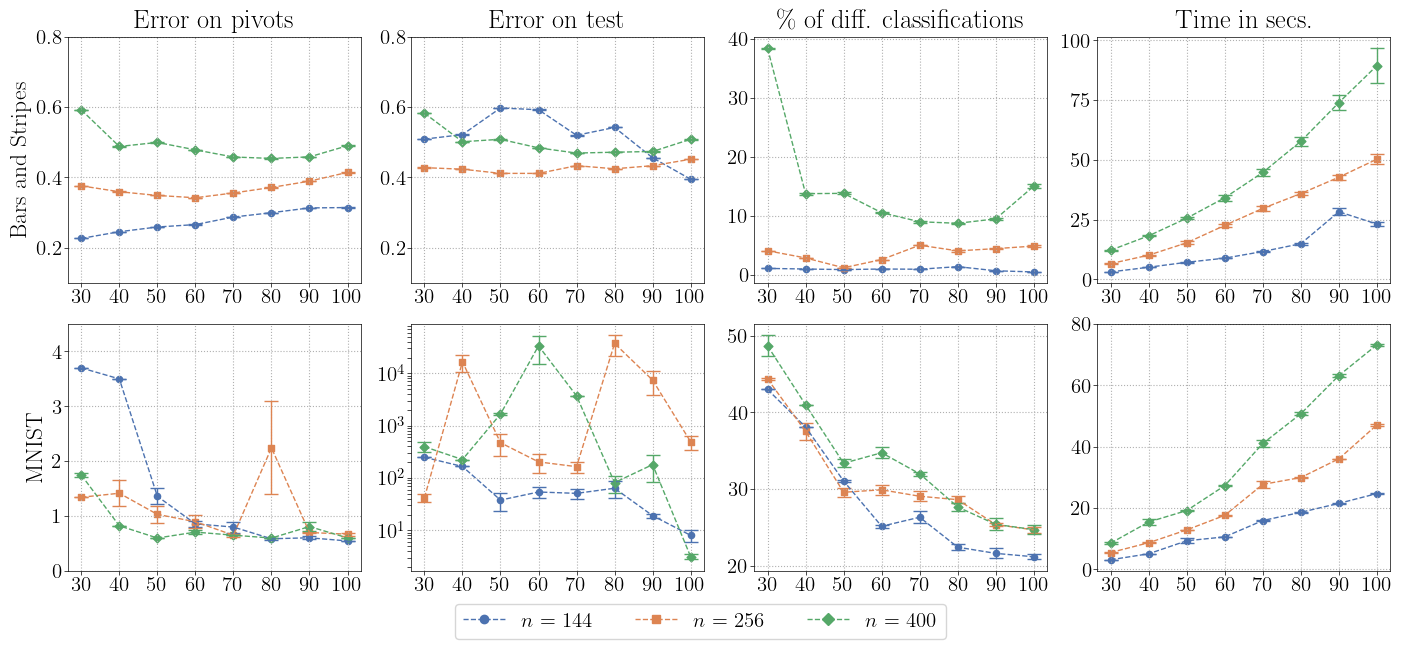

In [12]:
palette = sns.color_palette("deep")
colors = palette[0], palette[1], palette[2]

plt.rc('font', family='serif', serif='Computer Modern', size=16)
plt.rc('text', usetex=True)


# Set global font sizes
plt.rcParams['axes.linewidth'] = 0.5  # Default is usually 1.0
plt.rcParams['axes.titlesize'] = 19  # Title font size
plt.rcParams['axes.labelsize'] = 17  # Axis label font size
plt.rcParams['xtick.labelsize'] = 15  # X-axis tick label font size
plt.rcParams['ytick.labelsize'] = 15  # Y-axis tick label font size
plt.rcParams['legend.fontsize'] = 15


markers = ['o', 's', 'D']
labels = [r'$n$ = 144', r'$n$ = 256', r'$n$ = 400']

fig, axs = plt.subplots(2, 4, figsize=(14, 6))


# Bars Stripes
# ------------
sketch_size_list = [30, 40, 50, 60, 70, 80, 90, 100]

# Sketch
for i, n_features in enumerate([12, 16, 20]):
    means = torch.stack(list(map(lambda t: t[0],
                                 sketch_bars_stripes[n_features]))).tolist()
    stds = torch.stack(list(map(lambda t: t[1] * 0.5,
                                sketch_bars_stripes[n_features]))).tolist()

    axs[0, 0].errorbar(x=sketch_size_list, y=means, yerr=stds, capsize=5.,
                       linestyle='--', linewidth=1., color=colors[i])
    axs[0, 0].scatter(x=sketch_size_list, y=means, s=20.,
                      color=colors[i], marker=markers[i], label=labels[i])

# Set axes
axs[0, 0].set_ylabel('Bars and Stripes')
axs[0, 0].set_title('Error on pivots')

axs[0, 0].set_ylim(0.1, 0.8)
axs[0, 0].yaxis.grid(linestyle=':')
axs[0, 0].xaxis.grid(linestyle=':')

axs[0, 0].set_xticks(torch.arange(30, 110, 10))


# Errors
for i, n_features in enumerate([12, 16, 20]):
    means = torch.stack(list(map(lambda t: t[0],
                                 errors_bars_stripes[n_features]))).tolist()
    stds = torch.stack(list(map(lambda t: t[1] * 0.5,
                                errors_bars_stripes[n_features]))).tolist()

    axs[0, 1].errorbar(x=sketch_size_list, y=means, yerr=stds, capsize=5.,
                       linestyle='--', linewidth=1., color=colors[i])
    axs[0, 1].scatter(x=sketch_size_list, y=means, s=20.,
                      color=colors[i], marker=markers[i], label=labels[i])

# Set axes
axs[0, 1].set_title('Error on test')

axs[0, 1].set_ylim(0.1, 0.8)
axs[0, 1].yaxis.grid(linestyle=':')
axs[0, 1].xaxis.grid(linestyle=':')

axs[0, 1].set_xticks(torch.arange(30, 110, 10))

# Accuracies
for i, n_features in enumerate([12, 16, 20]):
    means = torch.stack(list(map(lambda t: t[0],
                                 accs_bars_stripes[n_features]))).tolist()
    stds = torch.stack(list(map(lambda t: t[1] * 0.5,
                                accs_bars_stripes[n_features]))).tolist()

    axs[0, 2].errorbar(x=sketch_size_list, y=means, yerr=stds, capsize=5.,
                       linestyle='--', linewidth=1., color=colors[i])
    axs[0, 2].scatter(x=sketch_size_list, y=means, s=20.,
                      color=colors[i], marker=markers[i], label=labels[i])

# Set axes
axs[0, 2].set_title('\% of diff. classifications')

# axs[0].set_ylim(-30, 40)
axs[0, 2].yaxis.grid(linestyle=':')
axs[0, 2].xaxis.grid(linestyle=':')

axs[0, 2].set_xticks(torch.arange(30, 110, 10))

# Times
for i, n_features in enumerate([12, 16, 20]):
    means = torch.stack(list(map(lambda t: t[0],
                                 times_bars_stripes[n_features]))).tolist()
    stds = torch.stack(list(map(lambda t: t[1] * 0.5,
                                times_bars_stripes[n_features]))).tolist()

    axs[0, 3].errorbar(x=sketch_size_list, y=means, yerr=stds, capsize=5.,
                       linestyle='--', linewidth=1., color=colors[i])
    axs[0, 3].scatter(x=sketch_size_list, y=means, s=20.,
                      color=colors[i], marker=markers[i], label=labels[i])

# Set axes
axs[0, 3].set_title('Time in secs.')

axs[0, 3].yaxis.grid(linestyle=':')
axs[0, 3].xaxis.grid(linestyle=':')

axs[0, 3].set_xticks(torch.arange(30, 110, 10))


# MNIST
# -----
sketch_size_list = [30, 40, 50, 60, 70, 80, 90, 100]

# Sketch
for i, n_features in enumerate([12, 16, 20]):
    means = torch.stack(list(map(lambda t: t[0],
                                 sketch_mnist[n_features]))).tolist()
    stds = torch.stack(list(map(lambda t: t[1] * 0.5,
                                sketch_mnist[n_features]))).tolist()

    axs[1, 0].errorbar(x=sketch_size_list, y=means, yerr=stds, capsize=5.,
                       linestyle='--', linewidth=1., color=colors[i])
    axs[1, 0].scatter(x=sketch_size_list, y=means, s=20.,
                      color=colors[i], marker=markers[i], label=labels[i])

# Set axes
axs[1, 0].set_ylabel('MNIST')

axs[1, 0].set_ylim(0, 4.5)
axs[1, 0].yaxis.grid(linestyle=':')
axs[1, 0].xaxis.grid(linestyle=':')

axs[1, 0].set_xticks(torch.arange(30, 110, 10))

# Errors
for i, n_features in enumerate([12, 16, 20]):
    means = torch.stack(list(map(lambda t: t[0],
                                 errors_mnist[n_features]))).tolist()
    stds = torch.stack(list(map(lambda t: t[1] * 0.5,
                                errors_mnist[n_features]))).tolist()

    axs[1, 1].errorbar(x=sketch_size_list, y=means, yerr=stds, capsize=5.,
                       linestyle='--', linewidth=1., color=colors[i])
    axs[1, 1].scatter(x=sketch_size_list, y=means, s=20.,
                      color=colors[i], marker=markers[i], label=labels[i])

# Set axes
axs[1, 1].yaxis.grid(linestyle=':')
axs[1, 1].xaxis.grid(linestyle=':')

axs[1, 1].set_yscale('log')

axs[1, 1].set_xticks(torch.arange(30, 110, 10))

# Accuracies
for i, n_features in enumerate([12, 16, 20]):
    means = torch.stack(list(map(lambda t: t[0],
                                 accs_mnist[n_features]))).tolist()
    stds = torch.stack(list(map(lambda t: t[1] * 0.5,
                                accs_mnist[n_features]))).tolist()

    axs[1, 2].errorbar(x=sketch_size_list, y=means, yerr=stds, capsize=5.,
                       linestyle='--', linewidth=1., color=colors[i])
    axs[1, 2].scatter(x=sketch_size_list, y=means, s=20.,
                      color=colors[i], marker=markers[i], label=labels[i])

# Set axes
axs[1, 2].yaxis.grid(linestyle=':')
axs[1, 2].xaxis.grid(linestyle=':')

axs[1, 2].set_xticks(torch.arange(30, 110, 10))

# Times
for i, n_features in enumerate([12, 16, 20]):
    means = torch.stack(list(map(lambda t: t[0],
                                 times_mnist[n_features]))).tolist()
    stds = torch.stack(list(map(lambda t: t[1] * 0.5,
                                times_mnist[n_features]))).tolist()

    axs[1, 3].errorbar(x=sketch_size_list, y=means, yerr=stds, capsize=5.,
                       linestyle='--', linewidth=1., color=colors[i])
    axs[1, 3].scatter(x=sketch_size_list, y=means, s=20.,
                      color=colors[i], marker=markers[i], label=labels[i])

# Set axes
axs[1, 3].yaxis.grid(linestyle=':')
axs[1, 3].xaxis.grid(linestyle=':')

axs[1, 3].set_xticks(torch.arange(30, 110, 10))
axs[1, 3].set_yticks(torch.arange(0, 100, 20))


# Create custom legend handles
from matplotlib.lines import Line2D

custom_handles = [
    Line2D([0], [0], color=color, linestyle='--', marker=marker, markersize=6, linewidth=1., label=label)
    for color, marker, label in zip(colors, markers, labels)
]

# Add a single legend to the figure
fig.legend(
    handles=custom_handles,
    loc='lower center',
    ncol=3,
    bbox_to_anchor=(0.5, -0.075),  # Centered below the plots
    # frameon=False
)


plt.tight_layout(pad=0.25)


for i in range(2):
    for j in range(4):
        axs[i, j].tick_params(axis='both', which='major', pad=1,
                              direction='out', length=3, width=0.5)  # Default is usually around 6-10
        axs[i, j].tick_params(axis='both', which='minor', pad=1,
                              direction='out', length=3, width=0.5)
        

results_dir = os.path.join(cwd, 'results', '1_performance')
plt.savefig(os.path.join(results_dir, 'performance_bars_stripes_mnist.pdf'),
            bbox_inches='tight')

plt.show()

### TT-CI

In [13]:
n_features_list = [12, 16, 20]
phys_dim = 2
bond_dim = 10
samples_size = 1000

results_dir = os.path.join(cwd, 'results', '1_performance', 'bars_stripes')

errors_bars_stripes = {}
tot_times_bars_stripes = {}
accs_bars_stripes = {}
times_bars_stripes = {}

print('Medians:\n--------')
for n_features in n_features_list:
    print(f'N. Features: {n_features}')
    
    aux_dir = f'cross_{n_features}_{phys_dim}_{bond_dim}_{samples_size}'
    files = os.listdir(os.path.join(results_dir, aux_dir))
    
    aux_tot_times = torch.Tensor([float(f.split('_')[0]) for f in files])
    aux_times = torch.Tensor([float(f.split('_')[1]) for f in files])
    aux_errors = torch.Tensor([float(f.split('_')[2]) for f in files])
    aux_accs = torch.Tensor([float(f.split('_')[3][:-3]) * 100 for f in files])
    
    # Remove outliers
    # aux_errors, ids = aux_errors.sort()
    # aux_times = aux_times[ids]
    
    q = torch.Tensor([0.25, 0.75])
    quantiles = aux_errors.quantile(q=q)
    iqr = quantiles[1] - quantiles[0]
    cond = (aux_errors >= (quantiles[0] - 1.5 * iqr)) * (aux_errors <= (quantiles[1] + 1.5 * iqr))
    aux_errors = aux_errors[cond]
    
    quantiles = aux_tot_times.quantile(q=q)
    iqr = quantiles[1] - quantiles[0]
    cond = (aux_tot_times >= (quantiles[0] - 1.5 * iqr)) * (aux_tot_times <= (quantiles[1] + 1.5 * iqr))
    aux_tot_times = aux_tot_times[cond]
    
    quantiles = aux_times.quantile(q=q)
    iqr = quantiles[1] - quantiles[0]
    cond = (aux_times >= (quantiles[0] - 1.5 * iqr)) * (aux_times <= (quantiles[1] + 1.5 * iqr))
    aux_times = aux_times[cond]
    
    quantiles = aux_accs.quantile(q=q)
    iqr = quantiles[1] - quantiles[0]
    cond = (aux_accs >= (quantiles[0] - 1.5 * iqr)) * (aux_accs <= (quantiles[1] + 1.5 * iqr))
    aux_accs = aux_accs[cond]
    
    print(f'\tTotal time: {aux_tot_times.median():.2e}, '
          f'Time: {aux_times.median():.2e}, '
          f'Test: {aux_errors.median():.2e}, '
          f'Accs: {aux_accs.median():.2e}')
    
    if n_features not in errors_bars_stripes:
        errors_bars_stripes[n_features] = [(aux_errors.mean(), aux_errors.std())]
        tot_times_bars_stripes[n_features] = [(aux_tot_times.mean(), aux_tot_times.std())]
        accs_bars_stripes[n_features] = [(aux_accs.mean(), aux_accs.std())]
        times_bars_stripes[n_features] = [(aux_times.mean(), aux_times.std())]
    else:
        errors_bars_stripes[n_features].append((aux_errors.mean(), aux_errors.std()))
        tot_times_bars_stripes[n_features].append((aux_tot_times.mean(), aux_tot_times.std()))
        accs_bars_stripes[n_features].append((aux_accs.mean(), aux_accs.std()))
        times_bars_stripes[n_features].append((aux_times.mean(), aux_times.std()))

print('\nMeans:\n------')

print('Errors:')
print(errors_bars_stripes)

print('Total times:')
print(tot_times_bars_stripes)

print('Times:')
print(times_bars_stripes)

print('Accuracies:')
print(accs_bars_stripes)

Medians:
--------
N. Features: 12
	Total time: 5.65e+02, Time: 4.23e+01, Test: 4.07e-01, Accs: 2.10e+00
N. Features: 16
	Total time: 1.70e+03, Time: 8.62e+01, Test: 4.39e-01, Accs: 1.50e+00
N. Features: 20
	Total time: 4.35e+03, Time: 1.55e+02, Test: 5.07e-01, Accs: 3.90e+00

Means:
------
Errors:
{12: [(tensor(0.4271), tensor(0.0491))], 16: [(tensor(0.4437), tensor(0.0417))], 20: [(tensor(0.4983), tensor(0.0369))]}
Total times:
{12: [(tensor(565.4445), tensor(0.8819))], 16: [(tensor(1715.), tensor(152.5966))], 20: [(tensor(4708.8887), tensor(737.1303))]}
Times:
{12: [(tensor(42.5300), tensor(0.6430))], 16: [(tensor(88.9222), tensor(8.3760))], 20: [(tensor(156.), tensor(1.3093))]}
Accuracies:
{12: [(tensor(2.1600), tensor(1.0752))], 16: [(tensor(1.6000), tensor(0.5385))], 20: [(tensor(6.3200), tensor(4.5171))]}


In [14]:
n_features_list = [12] #, 16, 20]
phys_dim = 4
bond_dim = 10
samples_size = 1000

results_dir = os.path.join(cwd, 'results', '1_performance', 'mnist')

errors_mnist = {}
tot_times_mnist = {}
accs_mnist = {}
times_mnist = {}

print('Medians:\n--------')
for n_features in n_features_list:
    print(f'N. Features: {n_features}')
    
    aux_dir = f'cross_{n_features}_{phys_dim}_{bond_dim}_{samples_size}'
    files = os.listdir(os.path.join(results_dir, aux_dir))
    
    aux_tot_times = torch.Tensor([float(f.split('_')[0]) for f in files])
    aux_times = torch.Tensor([float(f.split('_')[1]) for f in files])
    aux_errors = torch.Tensor([float(f.split('_')[2]) for f in files])
    aux_accs = torch.Tensor([float(f.split('_')[3][:-3]) * 100 for f in files])
    
    # Remove outliers
    # aux_errors, ids = aux_errors.sort()
    # aux_times = aux_times[ids]
    
    q = torch.Tensor([0.25, 0.75])
    quantiles = aux_errors.quantile(q=q)
    iqr = quantiles[1] - quantiles[0]
    cond = (aux_errors >= (quantiles[0] - 1.5 * iqr)) * (aux_errors <= (quantiles[1] + 1.5 * iqr))
    aux_errors = aux_errors[cond]
    
    quantiles = aux_tot_times.quantile(q=q)
    iqr = quantiles[1] - quantiles[0]
    cond = (aux_tot_times >= (quantiles[0] - 1.5 * iqr)) * (aux_tot_times <= (quantiles[1] + 1.5 * iqr))
    aux_tot_times = aux_tot_times[cond]
    
    quantiles = aux_times.quantile(q=q)
    iqr = quantiles[1] - quantiles[0]
    cond = (aux_times >= (quantiles[0] - 1.5 * iqr)) * (aux_times <= (quantiles[1] + 1.5 * iqr))
    aux_times = aux_times[cond]
    
    quantiles = aux_accs.quantile(q=q)
    iqr = quantiles[1] - quantiles[0]
    cond = (aux_accs >= (quantiles[0] - 1.5 * iqr)) * (aux_accs <= (quantiles[1] + 1.5 * iqr))
    aux_accs = aux_accs[cond]
    
    print(f'\tTotal time: {aux_tot_times.median():.2e}, '
          f'Time: {aux_times.median():.2e}, '
          f'Test: {aux_errors.median():.2e}, '
          f'Accs: {aux_accs.median():.2e}')
    
    if n_features not in errors_mnist:
        errors_mnist[n_features] = [(aux_errors.mean(), aux_errors.std())]
        tot_times_mnist[n_features] = [(aux_tot_times.mean(), aux_tot_times.std())]
        accs_mnist[n_features] = [(aux_accs.mean(), aux_accs.std())]
        times_mnist[n_features] = [(aux_times.mean(), aux_times.std())]
    else:
        errors_mnist[n_features].append((aux_errors.mean(), aux_errors.std()))
        tot_times_mnist[n_features].append((aux_tot_times.mean(), aux_tot_times.std()))
        accs_mnist[n_features].append((aux_accs.mean(), aux_accs.std()))
        times_mnist[n_features].append((aux_times.mean(), aux_times.std()))

print('\nMeans:\n------')

print('Errors:')
print(errors_mnist)

print('Total times:')
print(tot_times_mnist)

print('Times:')
print(times_mnist)

print('Accuracies:')
print(accs_mnist)

Medians:
--------
N. Features: 12
	Total time: 7.37e+02, Time: 2.12e+02, Test: 1.20e+00, Accs: 8.41e+01

Means:
------
Errors:
{12: [(tensor(1.2959), tensor(0.2610))]}
Total times:
{12: [(tensor(728.5000), tensor(25.6793))]}
Times:
{12: [(tensor(202.2000), tensor(17.8811))]}
Accuracies:
{12: [(tensor(84.8400), tensor(3.9342))]}
